In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

from network import Classifier
from dataset import add_hue_confounded, classifiedMNIST

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [2]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` 
# using the transform defined above

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('./data',train=True, transform=transform, download=True)
test_dataset =  datasets.MNIST('./data',train=False, transform=transform, download=True)

In [3]:
train_dataloader = Data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_dataloader = Data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=True)

In [11]:
accuracy = []
avg_loss = []
def test(model, device, test_loader, p_unif):
    model.eval()
    test_loss = 0
    correct = 0
    correct_more = 0
    with torch.no_grad():
        for data, target in test_loader:
          
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            data, hues = add_hue_confounded(data, target, p_unif=p_unif)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
          
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            correct_more += pred.eq(target.view_as(pred)).sum().item()

            # 四舍五入
            hues_label = torch.round(hues * 10 + 0.5) - 1
            correct_more += pred.eq(hues_label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) {:.0f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), 100.*correct_more/len(test_loader.dataset)))


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier().to(device)

classifier_name = 'model0.01_10'
state_dict = torch.load(f'./trained_classifiers/{classifier_name}.pt', map_location=device)
model.load_state_dict(state_dict)



<All keys matched successfully>

In [12]:
test(model, device, train_dataloader, 1)


Test set: Average loss: 0.6781, Accuracy: 50597/60000 (84%) 98



tensor([9], device='cuda:0')
tensor([0.7142], device='cuda:0')


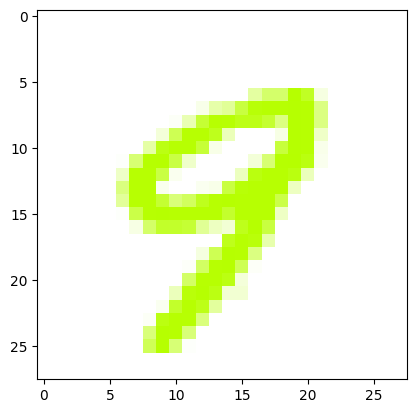

In [61]:
import matplotlib.pyplot as plt
small_dataloader = Data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)

for x, y in small_dataloader:
    x, y = x.to(device), y.to(device)
    x, hues = add_hue_confounded(x, y, p_unif=1)
    print(y)
    print(hues)
    break

plt.imshow((-1*x[0]+1).permute(1, 2, 0).cpu().numpy())

In [62]:
logits = model(x)
print(torch.exp(logits))

tensor([[0.0485, 0.0472, 0.0273, 0.1574, 0.0773, 0.0711, 0.0383, 0.1535, 0.0899,
         0.2893]], device='cuda:0', grad_fn=<ExpBackward0>)


In [10]:
# Construct a classified dataset (x, y, y_hat, logits, hue)
classified_dataset = []
import os
import tqdm
os.makedirs(f'./classifiedMNIST/{classifier_name}', exist_ok=True)
for i, (x, y) in enumerate(train_dataloader):
    x, y = x.to(device), y.to(device)
    x, hues = add_hue_confounded(x, y, p_unif=1)
    logits = model(x)
    y_hat = torch.argmax(logits, dim=1)
    torch.save((x, y, y_hat, logits, hues), f'./classifiedMNIST/{classifier_name}/batch_{i}.pth')

